## Importing necessary libraries

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

### Loading dataset

In [2]:
data = pd.read_csv("housing.csv")

#### Making a copy to work with

In [3]:
housing_data = data

In [4]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Planting random seed to facilitate identical sampling

In [5]:
np.random.seed(42)

#### Creating additional attribute to help perform stratified sampling

In [6]:
housing_data["income_cat"] = pd.cut(housing_data["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_data, housing_data["income_cat"]):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

In [8]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Train Set

In [9]:
housing_X_train = strat_train_set.drop("median_house_value", axis=1)
housing_y_train = strat_train_set["median_house_value"].copy()

## Test Set

In [ ]:
housing_X_test = strat_test_set.drop("median_house_value",axis=1)
housing_y_test = strat_test_set["median_house_value"].copy()

### Separating numerical and categorical attributes from the X_train set

In [10]:
housing_X_train_numerical = housing_X_train.drop("ocean_proximity", axis=1)

In [11]:
housing_X_train_categorical = housing_X_train[["ocean_proximity"]]

#### Defining imputer to fill in missing values

In [12]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

#### Defining one hot encoder for categorical variable "ocean proximity"

In [13]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

#### Defining class to add additional attributes (feature engineering)

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [housing_X_train_numerical.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

#### Adding pipeline to perform few operations on the dataset

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler()),])

#### Adding column transformer to facilitate pipeline operations on both numerical and categorical attributes

In [16]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_X_train_numerical)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),("cat", OneHotEncoder(), cat_attribs),])

housing_X_train_prepared = full_pipeline.fit_transform(housing_X_train)

In [17]:
housing_X_train_prepared.shape

(16512, 16)

In [18]:
housing_y_train.shape

(16512,)

#### Defining Linear Regression Model

In [19]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_X_train_prepared, housing_y_train)

LinearRegression()

#### Defining Decision Tree Regression Model

In [20]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_X_train_prepared, housing_y_train)

DecisionTreeRegressor(random_state=42)

#### Defining Random Forest Regression Model

In [21]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_X_train_prepared, housing_y_train)

RandomForestRegressor(random_state=42)

#### Predicting with linear regressor

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
housing_predictions_lin = lin_reg.predict(housing_X_train_prepared)   
lin_mse = mean_squared_error(housing_y_train, housing_predictions_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

#### Predicting with decision tree regressor

In [ ]:
housing_predictions_tree = tree_reg.predict(housing_X_train_prepared)              
tree_mse = mean_squared_error(housing_y_train, housing_predictions_tree)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

#### Predicting with random forest regressor

In [ ]:
housing_predictions_forest = forest_reg.predict(housing_X_train_prepared)
forest_mse = mean_squared_error(housing_y_train, housing_predictions_forest)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

#### Evaluation using Cross Validation for all regression models

In [23]:
from sklearn.model_selection import cross_val_score

In [24]:
lin_scores = cross_val_score(lin_reg, housing_X_train_prepared, housing_y_train,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [25]:
tree_scores = cross_val_score(tree_reg, housing_X_train_prepared, housing_y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [26]:
forest_scores = cross_val_score(forest_reg, housing_X_train_prepared, housing_y_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

##### Creating a function to display scores, mean and standard deviation

In [27]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [28]:
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180666


In [29]:
display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [30]:
display_scores(forest_rmse_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


#### Defining Support Vector Regression Model and initializing Grid Search to find optimal hyperparameters

In [31]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 100., 1000., 10000.]},
        {'kernel': ['rbf'], 'C': [1.0, 10., 100., 1000.0],
         'gamma': [0.01, 0.1, 1.0]},
    ]

svm_reg_grid = SVR()
grid_search = GridSearchCV(svm_reg_grid, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_X_train_prepared, housing_y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..............................C=10.0, kernel=linear; total time=   8.4s
[CV] END ..............................C=10.0, kernel=linear; total time=   5.3s
[CV] END ..............................C=10.0, kernel=linear; total time=   5.1s
[CV] END ..............................C=10.0, kernel=linear; total time=   5.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   5.0s
[CV] END .............................C=100.0, kernel=linear; total time=   5.1s
[CV] END .............................C=100.0, kernel=linear; total time=   5.0s
[CV] END .............................C=100.0, kernel=linear; total time=   4.9s
[CV] END .............................C=100.0, kernel=linear; total time=   5.1s
[CV] END .............................C=100.0, kernel=linear; total time=   5.1s
[CV] END ............................C=1000.0, kernel=linear; total time=   5.1s
[CV] END ............................C=1000.0, k

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 100.0, 1000.0, 10000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 10.0, 100.0, 1000.0],
                          'gamma': [0.01, 0.1, 1.0], 'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [32]:
grid_search.best_params_

{'C': 10000.0, 'kernel': 'linear'}

In [33]:
svm_reg_best = SVR(kernel="linear",C=10000)
svm_reg_best.fit(housing_X_train_prepared, housing_y_train)

svm_scores = cross_val_score(svm_reg_best, housing_X_train_prepared, housing_y_train,
                                scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)

In [34]:
display_scores(svm_rmse_scores)

Scores: [72594.25749668 66077.21607085 67127.38810235 70239.3677623
 67134.74071207 73922.46981788 77137.8945368  70000.30379852
 67545.14984035 70930.05529475]
Mean: 70270.88434325633
Standard deviation: 3333.6185955727083


#### Creating graphs to compare results of different regression models

In [35]:
from sklearn.metrics import r2_score

In [42]:
lin_mse_scores = -lin_scores

In [48]:
lin_mse_score = sum(lin_mse_scores)/len(lin_mse_scores)
print(lin_mse_score)

4783670160.819973


In [36]:
lin_rmse_scores

array([71762.76364394, 64114.99166359, 67771.17124356, 68635.19072082,
       66846.14089488, 72528.03725385, 73997.08050233, 68802.33629334,
       66443.28836884, 70139.79923956])

In [49]:
lin_rmse_score = sum(lin_rmse_scores)/len(lin_rmse_scores)
print(lin_rmse_score)

69104.07998247063


In [43]:
tree_mse_scores = -tree_scores

In [50]:
tree_mse_score = sum(tree_mse_scores)/len(tree_mse_scores)
print(tree_mse_score)

5139332758.0591755


In [37]:
tree_rmse_scores

array([72831.45749112, 69973.18438322, 69528.56551415, 72517.78229792,
       69145.50006909, 79094.74123727, 68960.045444  , 73344.50225684,
       69826.02473916, 71077.09753998])

In [51]:
tree_rmse_score = sum(tree_rmse_scores)/len(tree_rmse_scores)
print(tree_rmse_score)

71629.89009727491


In [44]:
forest_mse_scores = -forest_scores

In [52]:
forest_mse_score = sum(forest_mse_scores)/len(forest_mse_scores)
print(forest_mse_score)

2548602521.7694273


In [38]:
forest_rmse_scores

array([51559.63379638, 48737.57100062, 47210.51269766, 51875.21247297,
       47577.50470123, 51863.27467888, 52746.34645573, 50065.1762751 ,
       48664.66818196, 54055.90894609])

In [53]:
forest_rmse_score = sum(forest_rmse_scores)/len(forest_rmse_scores)
print(forest_rmse_score)

50435.5809206618


In [46]:
svm_mse_scores = -svm_scores

In [54]:
svm_mse_score = sum(svm_mse_scores)/len(svm_mse_scores)
print(svm_mse_score)

4949110199.324055


In [39]:
svm_rmse_scores

array([72594.25749668, 66077.21607085, 67127.38810235, 70239.3677623 ,
       67134.74071207, 73922.46981788, 77137.8945368 , 70000.30379852,
       67545.14984035, 70930.05529475])

In [55]:
svm_rmse_score = sum(svm_rmse_scores)/len(svm_rmse_scores)
print(svm_rmse_score)

70270.88434325633


In [56]:
mse_scores = (lin_mse_score,tree_mse_score,forest_mse_score,svm_mse_score)

In [57]:
print(mse_scores)

(4783670160.819973, 5139332758.0591755, 2548602521.7694273, 4949110199.324055)


In [58]:
rmse_scores = (lin_rmse_score,tree_rmse_score,forest_rmse_score,svm_rmse_score)

In [59]:
print(rmse_scores)

(69104.07998247063, 71629.89009727491, 50435.5809206618, 70270.88434325633)


In [61]:
housing_lin_pred = lin_reg.predict(housing_X_train_prepared)
housing_tree_pred = tree_reg.predict(housing_X_train_prepared)
housing_forest_pred = forest_reg.predict(housing_X_train_prepared)
housing_svm_pred = svm_reg_best.predict(housing_X_train_prepared)

In [63]:
r2_lin = r2_score(housing_y_train, housing_lin_pred)
r2_tree = r2_score(housing_y_train, housing_tree_pred)
r2_forest = r2_score(housing_y_train, housing_forest_pred)
r2_svm = r2_score(housing_y_train, housing_svm_pred)

r2_scores = (r2_lin,r2_tree,r2_forest,r2_svm)

In [64]:
print(r2_scores)

(0.6481553634454353, 1.0, 0.9740139626391636, 0.6320836765382409)


In [65]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel="linear",C=30000)
}

model_names = list(models.keys())

In [66]:
import os
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="jpg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

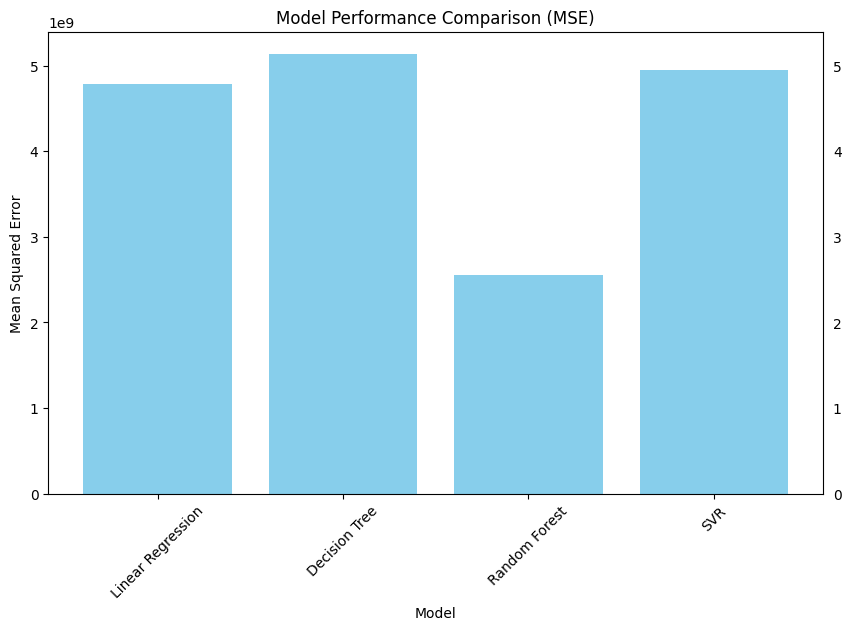

Saving figure MSE Barplot


<Figure size 640x480 with 0 Axes>

In [67]:
plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_scores, color='skyblue')
plt.tick_params(labeltop=False, labelright=True)
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('Model Performance Comparison (MSE)')
plt.xticks(rotation=45)
plt.show()
save_fig("MSE Barplot")

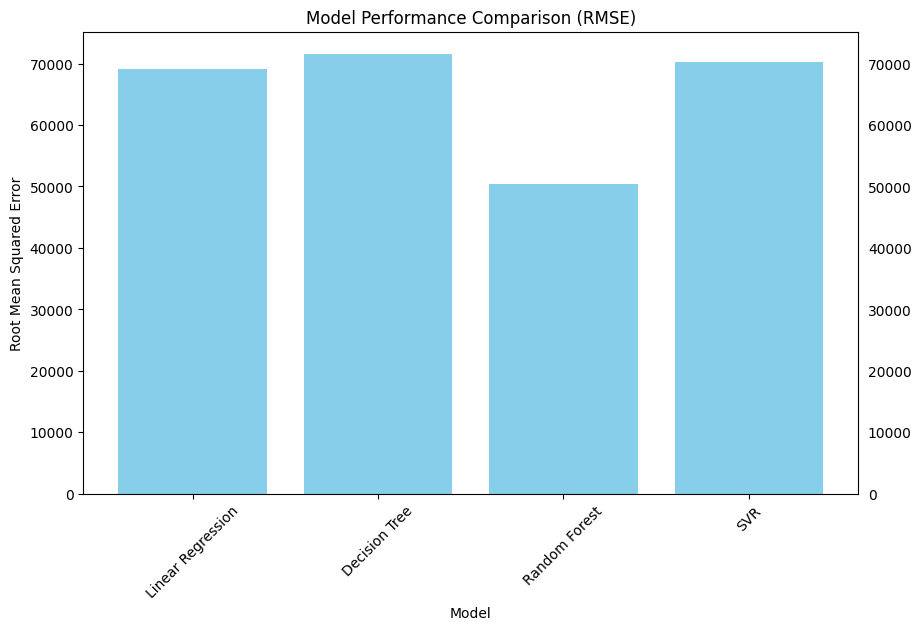

Saving figure RMSE Barplot


<Figure size 640x480 with 0 Axes>

In [68]:
plt.figure(figsize=(10, 6))
plt.bar(model_names, rmse_scores, color='skyblue')
plt.tick_params(labeltop=False, labelright=True)
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error')
plt.title('Model Performance Comparison (RMSE)')
plt.xticks(rotation=45)
plt.show()
save_fig("RMSE Barplot")

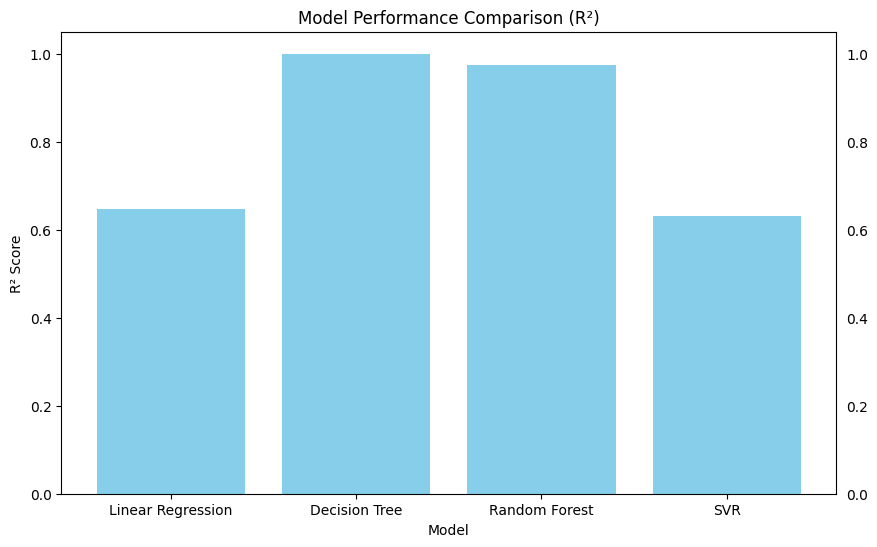

Saving figure R² Barplot


<Figure size 640x480 with 0 Axes>

In [69]:
plt.figure(figsize=(10, 6))
plt.bar(model_names, r2_scores, color='skyblue')
plt.tick_params(labeltop=False, labelright=True)
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison (R²)')
plt.show()
save_fig("R² Barplot")